In [1]:
# Transfer Learning with Resnet18

import warnings
warnings.simplefilter('ignore')

In [2]:
from resnet_transfer import *
from resnet_transfer import Resnet_18_Transfer

In [3]:
# Training parameter
num_epochs = 3           
batch_size = 16          
seed = np.random.seed(123) 

In [4]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: 
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [5]:
class channel_copy(object):
    def __call__(self, img):
        return torch.cat([img, img, img], 0)
    
transform = transforms.Compose([transforms.Resize(512), transforms.ToTensor(), channel_copy()])
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform = transform, 
                                                             p_val = 0.1, p_test = 0.2,
                                                             shuffle = True, show_sample = False, 
                                                             extras = extras)

In [6]:
from loss import *

model = Resnet_18_Transfer(num_classes = 14)
model = model.to(computing_device)

criterion = weighted_focal_loss()

In [7]:
# Hyperparameter tuning on the validation set

losses = []
for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    print("\nLearning Rate: ", learning_rate)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    total_loss = []
    avg_minibatch_loss = []
    epochs = 2
    for epoch in range(epochs):
        N = 25
        N_minibatch_loss = 0.0 
        for minibatch_count, (images, labels) in enumerate(val_loader, 0):

            images, labels = images.to(computing_device), labels.to(computing_device)
            optimizer.zero_grad()
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backprop
            optimizer.step() # weight update

            total_loss.append(loss.item())
            N_minibatch_loss += loss

            if (minibatch_count + 1) % N == 0:      
                N_minibatch_loss /= N
                print('Epoch: %d ! Average minibatch %d loss: %.3f' %
                    (epoch + 1, minibatch_count + 1, N_minibatch_loss))
                avg_minibatch_loss.append(N_minibatch_loss)
                N_minibatch_loss = 0.0

    losses.append(avg_minibatch_loss)  


Learning Rate:  0.1
Epoch: 1 ! Average minibatch 25 loss: 3.289
Epoch: 1 ! Average minibatch 50 loss: 1.614
Epoch: 1 ! Average minibatch 75 loss: 1.367
Epoch: 1 ! Average minibatch 100 loss: 0.879
Epoch: 1 ! Average minibatch 125 loss: 0.745
Epoch: 2 ! Average minibatch 25 loss: 0.966
Epoch: 2 ! Average minibatch 50 loss: 0.602
Epoch: 2 ! Average minibatch 75 loss: 0.492
Epoch: 2 ! Average minibatch 100 loss: 0.979
Epoch: 2 ! Average minibatch 125 loss: 0.977

Learning Rate:  0.01
Epoch: 1 ! Average minibatch 25 loss: 0.802
Epoch: 1 ! Average minibatch 50 loss: 0.276
Epoch: 1 ! Average minibatch 75 loss: 0.270
Epoch: 1 ! Average minibatch 100 loss: 0.195
Epoch: 1 ! Average minibatch 125 loss: 0.184
Epoch: 2 ! Average minibatch 25 loss: 0.192
Epoch: 2 ! Average minibatch 50 loss: 0.208
Epoch: 2 ! Average minibatch 75 loss: 0.182
Epoch: 2 ! Average minibatch 100 loss: 0.172
Epoch: 2 ! Average minibatch 125 loss: 0.164

Learning Rate:  0.001
Epoch: 1 ! Average minibatch 25 loss: 0.195
Ep

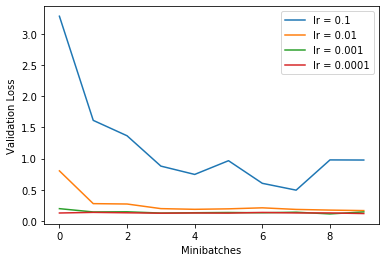

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(losses[0], label = 'lr = 0.1')
ax.plot(losses[1], label = 'lr = 0.01')
ax.plot(losses[2], label = 'lr = 0.001')
ax.plot(losses[3], label = 'lr = 0.0001')
plt.ylabel('Validation Loss')
plt.xlabel('Minibatches')
plt.savefig('Plots/resnet_lr.png')
ax.legend()
plt.show()

In [10]:
losses = []
for weight_decay in [0.01, 0.001, 0.0001, 0.00001]:
    print("\nRegularization Strength: ", weight_decay)
    optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = weight_decay)
    total_loss = []
    avg_minibatch_loss = []
    epochs = 2
    for epoch in range(epochs):
        N = 25
        N_minibatch_loss = 0.0 
        for minibatch_count, (images, labels) in enumerate(val_loader, 0):

            images, labels = images.to(computing_device), labels.to(computing_device)
            optimizer.zero_grad()
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backprop
            optimizer.step() # weight update

            total_loss.append(loss.item())
            N_minibatch_loss += loss

            if (minibatch_count + 1) % N == 0:      
                N_minibatch_loss /= N
                print('Epoch: %d ! Average minibatch %d loss: %.3f' %
                    (epoch + 1, minibatch_count + 1, N_minibatch_loss))
                avg_minibatch_loss.append(N_minibatch_loss)
                N_minibatch_loss = 0.0

    losses.append(avg_minibatch_loss) 


Regularization Strength:  0.01
Epoch: 1 ! Average minibatch 25 loss: 0.190
Epoch: 1 ! Average minibatch 50 loss: 0.177
Epoch: 1 ! Average minibatch 75 loss: 0.189
Epoch: 1 ! Average minibatch 100 loss: 0.188
Epoch: 1 ! Average minibatch 125 loss: 0.207
Epoch: 2 ! Average minibatch 25 loss: 0.211
Epoch: 2 ! Average minibatch 50 loss: 0.191
Epoch: 2 ! Average minibatch 75 loss: 0.203
Epoch: 2 ! Average minibatch 100 loss: 0.197
Epoch: 2 ! Average minibatch 125 loss: 0.237

Regularization Strength:  0.001
Epoch: 1 ! Average minibatch 25 loss: 0.250
Epoch: 1 ! Average minibatch 50 loss: 0.206
Epoch: 1 ! Average minibatch 75 loss: 0.201
Epoch: 1 ! Average minibatch 100 loss: 0.182
Epoch: 1 ! Average minibatch 125 loss: 0.209
Epoch: 2 ! Average minibatch 25 loss: 0.218
Epoch: 2 ! Average minibatch 50 loss: 0.210
Epoch: 2 ! Average minibatch 75 loss: 0.192
Epoch: 2 ! Average minibatch 100 loss: 0.198
Epoch: 2 ! Average minibatch 125 loss: 0.207

Regularization Strength:  0.0001
Epoch: 1 ! Av

In [12]:
# Training the model on best hyperparameters

total_loss = []
avg_minibatch_loss = []
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001) 
for epoch in range(num_epochs):
    N = 50
    N_minibatch_loss = 0.0 
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):

        images, labels = images.to(computing_device), labels.to(computing_device)
        optimizer.zero_grad()
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels) # compute loss
        loss.backward() # backprop
        optimizer.step() # weight update

        total_loss.append(loss.item())
        N_minibatch_loss += loss
        
        if (minibatch_count + 1) % N == 0:      
            N_minibatch_loss /= N
            print('Epoch: %d ! Average minibatch %d loss: %.3f' %
                (epoch + 1, minibatch_count + 1, N_minibatch_loss))
            avg_minibatch_loss.append(N_minibatch_loss)
            N_minibatch_loss = 0.0

    print("Finished", epoch + 1, "epochs of training")
print("Training complete after", epoch + 1, "epochs")

Epoch: 1 ! Average minibatch 50 loss: 0.267
Epoch: 1 ! Average minibatch 100 loss: 0.202
Epoch: 1 ! Average minibatch 150 loss: 0.199
Epoch: 1 ! Average minibatch 200 loss: 0.210
Epoch: 1 ! Average minibatch 250 loss: 0.199
Epoch: 1 ! Average minibatch 300 loss: 0.184
Epoch: 1 ! Average minibatch 350 loss: 0.193
Epoch: 1 ! Average minibatch 400 loss: 0.198
Epoch: 1 ! Average minibatch 450 loss: 0.208
Epoch: 1 ! Average minibatch 500 loss: 0.203
Epoch: 1 ! Average minibatch 550 loss: 0.193
Epoch: 1 ! Average minibatch 600 loss: 0.196
Epoch: 1 ! Average minibatch 650 loss: 0.197
Epoch: 1 ! Average minibatch 700 loss: 0.208
Epoch: 1 ! Average minibatch 750 loss: 0.212
Epoch: 1 ! Average minibatch 800 loss: 0.204
Epoch: 1 ! Average minibatch 850 loss: 0.195
Epoch: 1 ! Average minibatch 900 loss: 0.235
Epoch: 1 ! Average minibatch 950 loss: 0.230
Epoch: 1 ! Average minibatch 1000 loss: 0.200
Finished 1 epochs of training
Epoch: 2 ! Average minibatch 50 loss: 0.205
Epoch: 2 ! Average minibat

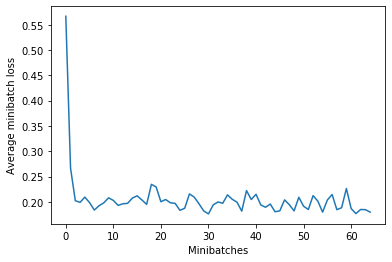

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylabel('Average minibatch loss')
plt.xlabel('Minibatches')
plt.plot(avg_minibatch_loss)
plt.savefig('Plots/resnet_loss.png')
plt.show()

In [26]:
# Testing the model

from test import *
from test import Test_Model

In [27]:
labels_all = []
predictions_all = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(computing_device), labels.to(computing_device)
        labels_all.append(labels)
        output = model(images)
        predictions = output > 0.5
        predictions_all.append(predictions)

labels = torch.cat(labels_all, 0)
predctions = torch.cat(predictions_all, 0)
test_res = Test_Model(predctions.float(), labels)
accuracy = test_res.avg_accuracy().item()
precision = test_res.avg_precision().item()
recall = test_res.avg_recall().item()
BCR = test_res.avg_BCR().item()

In [32]:
print("Test Statistics: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("BCR: ", BCR)

Test Statistics: 
Accuracy:  0.7035
Precision:  0.3032
Recall:  0.4888
BCR:  0.396
